In [ ]:
# Figure 4, synthesis manuscript

In [1]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.colors
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [5]:
p50 = ['ACTR3B', 'ANLN', 'BAG1', 'BCL2', 'BIRC5', 'BLVRA', 'CCNB1', 'CCNE1', 'CDC20', 'CDC6', 'CDH3', 'CENPF', 'CEP55', 'CXXC5', 'EGFR', 'ERBB2', 'ESR1', 'EXO1',
       'FGFR4', 'FOXA1', 'FOXC1', 'GPR160', 'GRB7', 'KIF2C', 'KRT14', 'KRT17', 'KRT5', 'MAPT', 'MDM2', 'MELK', 'MIA', 'MKI67', 'MLPH', 'MMP11', 'MYBL2', 'MYC', 'NAT1',
       'NDC80', 'NUF2', 'ORC6L', 'PGR', 'PHGDH', 'PTTG1', 'RRM2', 'SFRP1', 'SLC39A6', 'TMEM45B', 'TYMS', 'UBE2C', 'UBE2T']

In [15]:
orig_pths = sorted(glob.glob('i_o/originals/*.tsv'))
recd_pths = sorted(glob.glob('i_o/BRCA/decoded_objs/*.tsv'))
synth_pths = sorted(glob.glob('i_o/BRCA/synthetic_sample_sets/*.tsv'))

stor = pd.DataFrame()
for pth_idx, pth in enumerate(orig_pths):

    vs = orig_pths[pth_idx].split('.')[0].split('_')[-1]
    o_file = pd.read_csv(orig_pths[pth_idx], sep = '\t', index_col = 0)
    o_file.insert(0,'Data_phase','Original')
    
    r_file = pd.read_csv(recd_pths[pth_idx], sep = '\t', index_col = 0)
    r_file.insert(0,'Data_phase','Re-coded')
    
    s_file = pd.read_csv(synth_pths[pth_idx], sep = '\t', index_col = 0)
    s_file.insert(0,'Data_phase','Synthetic') # 800
    
    full_set = pd.concat([o_file, r_file, s_file])
    
    stor = pd.concat([stor, full_set])

In [16]:
stor.to_csv('stor.tsv', sep = '\t')

### Start from disk object

In [2]:
stor = pd.read_csv('stor.tsv', sep = '\t', index_col = 0)

In [6]:
p50_present = []
for col in stor.columns[2:]: # Go through only the gene columns
    if col.split(':')[3] in (p50): # check against the p50 list
        p50_present.append(col)

In [7]:
len(p50_present)

35

In [8]:
p50_plus = ['Data_phase', 'Labels']+p50_present # * <--- put the phase and Labels column headers back on

In [9]:
stor_p50 = stor.loc[:, p50_plus] # * <--- Extract the mapped PAM50 columns

In [10]:
stor_p50.shape

(21600, 37)

In [11]:
del(stor)

In [12]:
og = stor_p50[stor_p50.Data_phase == 'Original'].drop_duplicates()

In [13]:
len(og)

641

In [14]:
og.Labels.value_counts() # Original

Labels
BRCA_1    338
BRCA_2    127
BRCA_3    118
BRCA_4     58
Name: count, dtype: int64

In [18]:
sn = stor_p50[stor_p50.Data_phase == 'Synthetic'].sample(1000) # <--- Sampling will affect the clustering

In [19]:
len(sn)

1000

In [20]:
sn.Labels.value_counts()

Labels
BRCA_2    290
BRCA_1    268
BRCA_3    245
BRCA_4    197
Name: count, dtype: int64

In [21]:
subtype_rgbs = {'BRCA_3': (0.8, 0.0, 0.0),
                'BRCA_1': (0.0, 0.0, 0.8),
                'BRCA_4': (1.0, 0.2, 1.0),
                'BRCA_2': (0.0, 0.8, 1.0)}
handles = [Patch(facecolor=subtype_rgbs[name]) for name in subtype_rgbs]

### Two-phase

In [158]:
og = stor_p50[stor_p50.Data_phase == 'Original'].drop_duplicates()
sn = stor_p50[stor_p50.Data_phase == 'Synthetic'].sample(1000)

In [24]:
# Begin Version 1 production, fix the gene labels
new_col = []
for col in og.columns[2:]:
    new_col.append(col.split(':')[3])

In [25]:
new_col = ['Data_phase', 'Labels']+new_col

In [26]:
og.columns = new_col

/Users/karlberb/miniforge3/envs/synth_fig_1b/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/karlberb/miniforge3/envs/synth_fig_1b/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


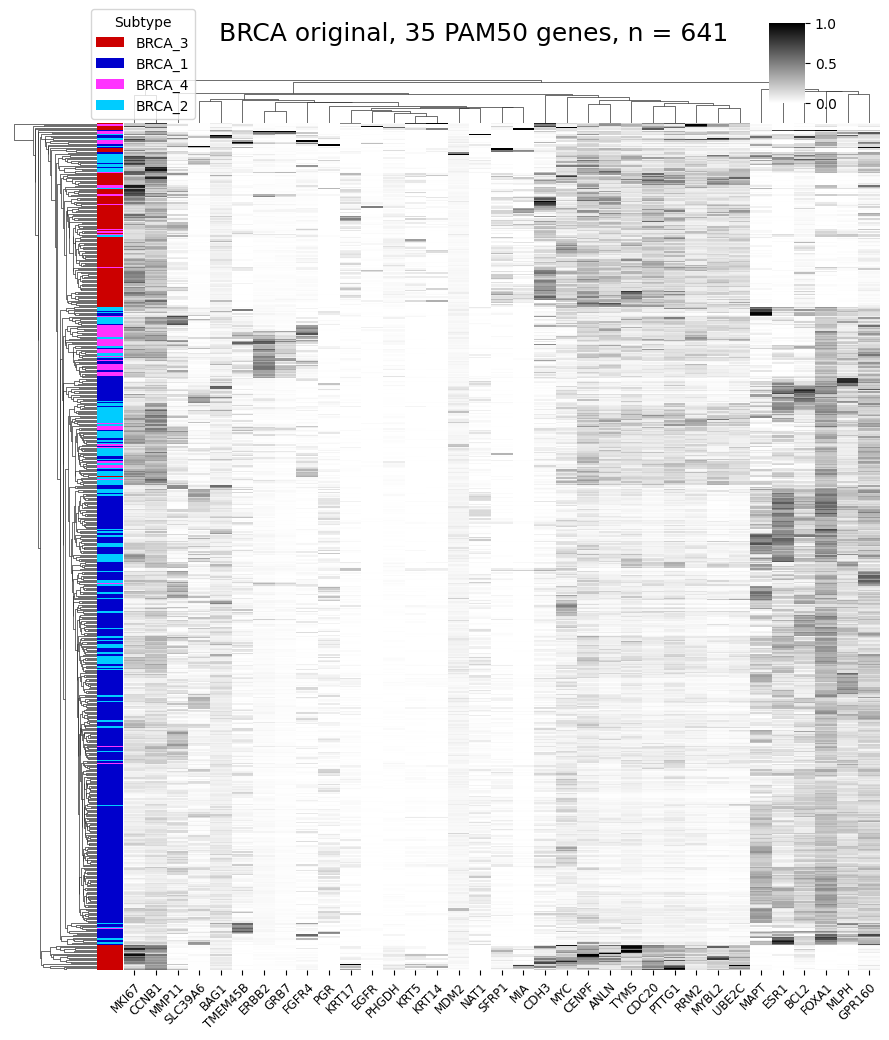

In [28]:
col_list = []
for item in og.Labels:
    if item == 'BRCA_1':
        col_list.append((0.0, 0.0, 0.8))
    if item == 'BRCA_2':
        col_list.append((0.0, 0.8, 1.0))        
    if item == 'BRCA_3':
        col_list.append((0.8, 0.0, 0.0))        
    if item == 'BRCA_4':
        col_list.append((1.0, 0.2, 1.0))
c_df = pd.DataFrame({'Subtypes': col_list}, index=og.index)
nest = sns.clustermap(og.iloc[:, 2:],
                      cmap="gray_r",
                      yticklabels=0,
                      row_colors=col_list,
                      dendrogram_ratio=(.1, .05),
                      cbar_pos=(.86, .96, .04, .08),
                      figsize=(9, 10))
plt.setp(nest.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize = 8.5, ha = 'right', rotation_mode='anchor')

plt.annotate('      BRCA original, 35 PAM50 genes, n = '+str(len(og)), (.5, 1.0), xycoords = 'figure fraction',
            horizontalalignment='center', fontsize = 18)
plt.legend(handles, subtype_rgbs, title='Subtype',
           bbox_to_anchor=(0.122, 1.04), bbox_transform=plt.gcf().transFigure, loc='upper left', borderaxespad=-1)
nest.savefig('og_dbl_clstr_gr_v1.png', dpi = 300) # Check

In [29]:
ro_frm = pd.DataFrame(og.columns[2:])

In [30]:
extract_order = ro_frm.reindex(nest.dendrogram_col.reordered_ind)

In [33]:
sn_new_col = []
for col in sn.columns[2:]:
    sn_new_col.append(col.split(':')[3])
sn_new_col = ['Data_phase', 'Labels']+sn_new_col
sn.columns = sn_new_col

In [34]:
ext_ord = list(extract_order[0])

In [35]:
ext_ord = ['Data_phase', 'Labels'] + ext_ord

In [37]:
sn = sn[ext_ord]

/Users/karlberb/miniforge3/envs/synth_fig_1b/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


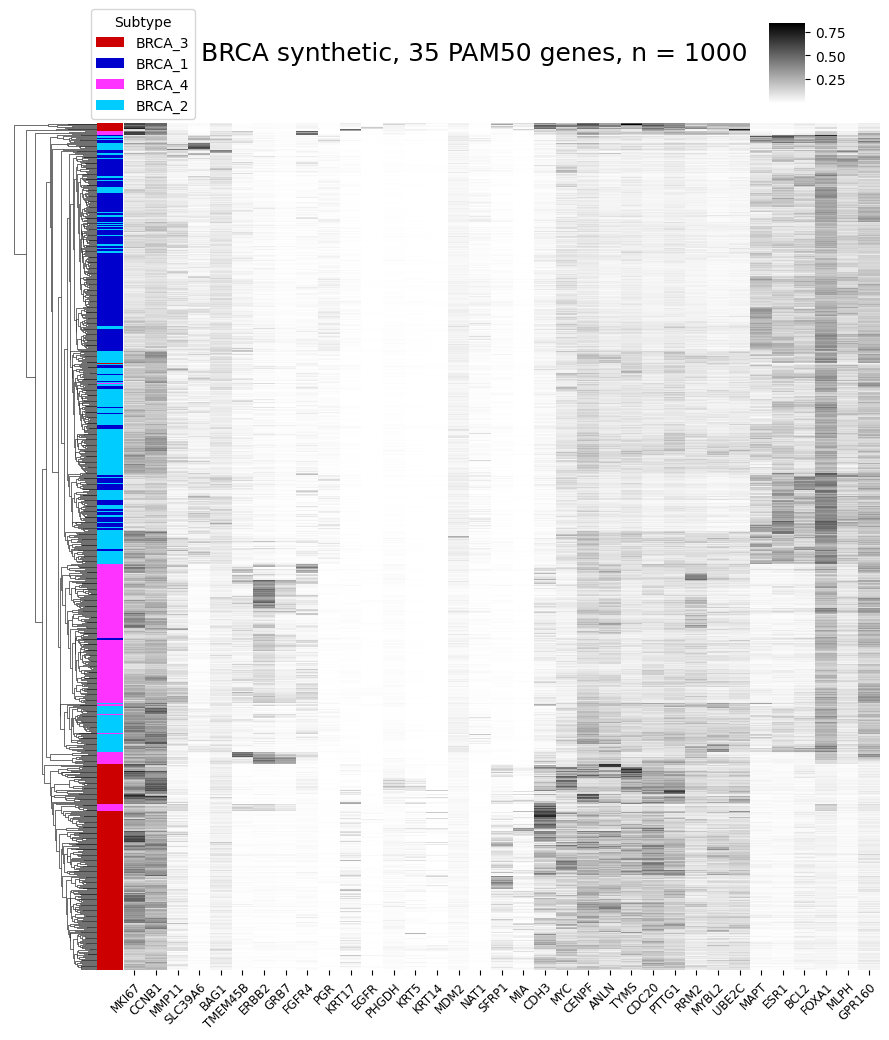

In [38]:
# Synthetic with column lock
phs = sn
col_list = []
for item in phs.Labels:
    if item == 'BRCA_1':
        col_list.append((0.0, 0.0, 0.8))
    if item == 'BRCA_2':
        col_list.append((0.0, 0.8, 1.0))        
    if item == 'BRCA_3':
        col_list.append((0.8, 0.0, 0.0))        
    if item == 'BRCA_4':
        col_list.append((1.0, 0.2, 1.0))
c_df = pd.DataFrame({'Subtypes': col_list}, index=phs.index)

nest = sns.clustermap(phs.iloc[:, 2:],
                      cmap="gray_r",
                      yticklabels=0,
                      # xticklabels=0,
                      row_colors=col_list,
                      col_cluster = False,
                      dendrogram_ratio=(.1, .05),
                      cbar_pos=(.86, .96, .04, .08),
                      figsize=(9, 10))
plt.setp(nest.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize = 8.5, ha = 'right', rotation_mode='anchor')

plt.annotate('      BRCA synthetic, 35 PAM50 genes, n = '+str(len(phs)), (.5, .98), xycoords = 'figure fraction',
            horizontalalignment='center', fontsize = 18)
plt.legend(handles, subtype_rgbs, title='Subtype',
           bbox_to_anchor=(0.122, 1.04), bbox_transform=plt.gcf().transFigure, loc='upper left', borderaxespad=-1)
nest.savefig('sn_dbl_clstr_gr_v1.png', dpi = 300)

In [39]:
two_phs = pd.concat([sn, og])

In [40]:
phs_list = []
for itm in two_phs.Data_phase:
        if itm == 'Original':
            phs_list.append((0.5333333333333333, 0.6078431372549019, 0.6823529411764706))
        if itm == 'Synthetic':
            phs_list.append((0.41568627450980394, 0.1411764705882353, 0.20784313725490197))

(0.5333333333333333, 0.6078431372549019, 0.6823529411764706)


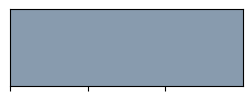

In [41]:
print(matplotlib.colors.to_rgb('#889bae'))
sns.palplot(matplotlib.colors.to_rgb('#889bae'))

In [42]:
phs_rgbs = {'Original': (0.5333333333333333, 0.6078431372549019, 0.6823529411764706),
                'Synthetic': (0.41568627450980394, 0.1411764705882353, 0.20784313725490197)}
handles_phs = [Patch(facecolor=phs_rgbs[name]) for name in phs_rgbs]

/Users/karlberb/miniforge3/envs/synth_fig_1b/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


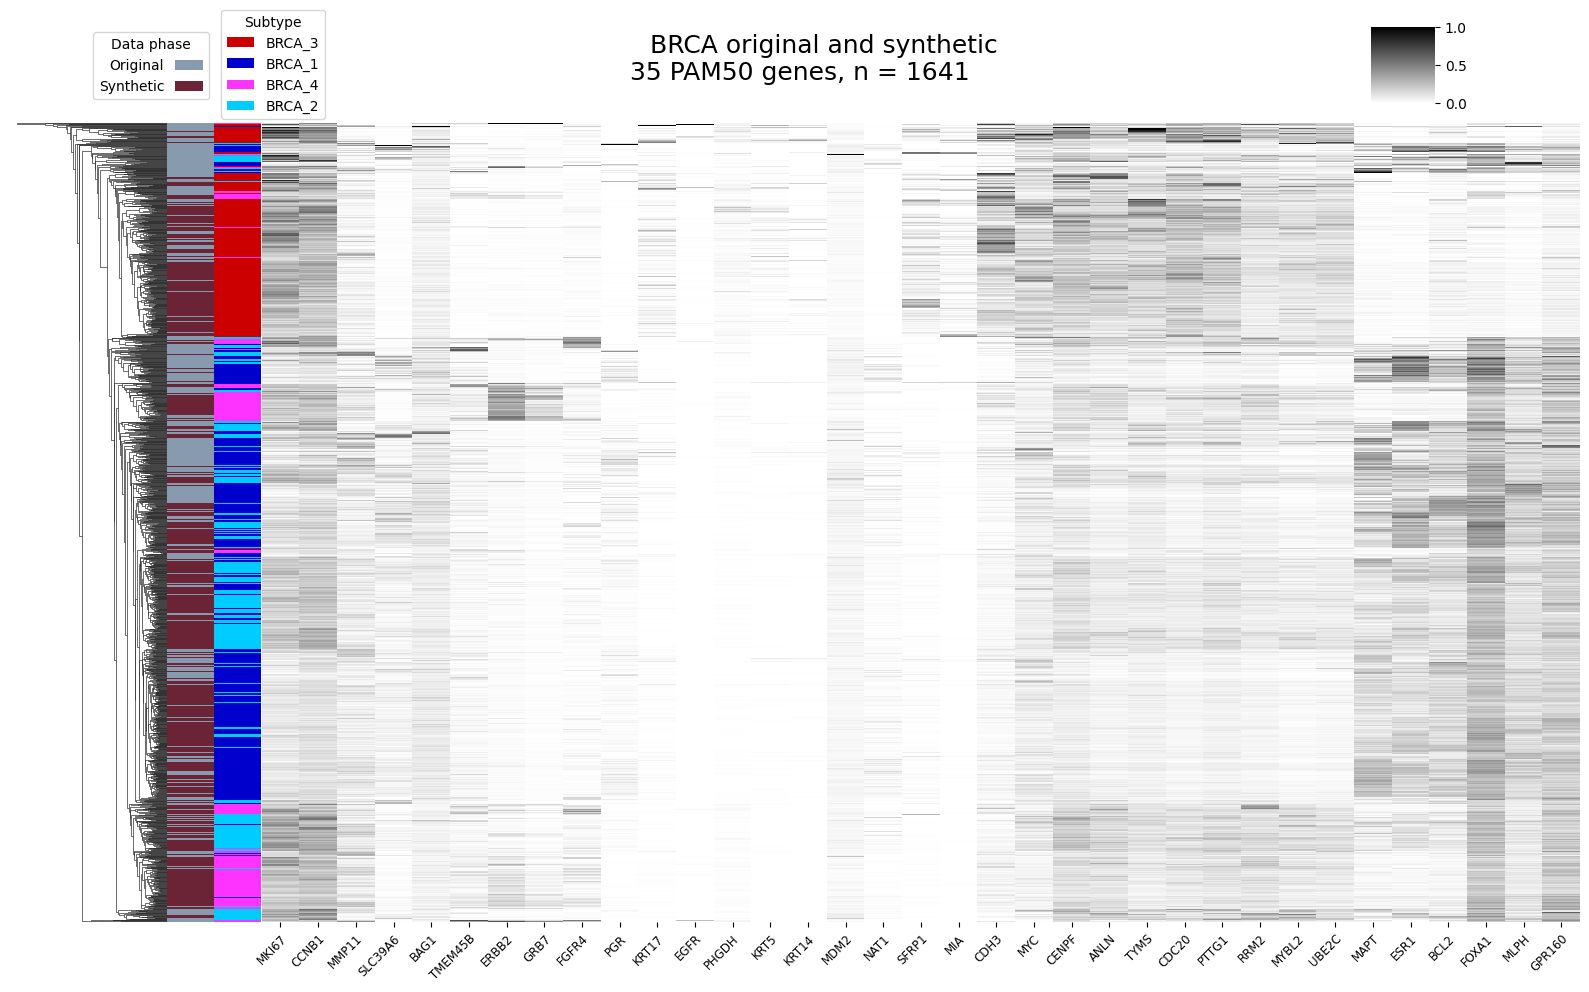

In [43]:
phs = two_phs
col_list = []
for item in phs.Labels:
    if item == 'BRCA_1':
        col_list.append((0.0, 0.0, 0.8))
    if item == 'BRCA_2':
        col_list.append((0.0, 0.8, 1.0))        
    if item == 'BRCA_3':
        col_list.append((0.8, 0.0, 0.0))        
    if item == 'BRCA_4':
        col_list.append((1.0, 0.2, 1.0))
c_df = pd.DataFrame({'Subtypes': col_list}, index=phs.index)

nest = sns.clustermap(phs.iloc[:, 2:],
                      cmap="gray_r",
                      yticklabels=0,
                      row_colors=[phs_list,col_list],
                      col_cluster = False,
                      dendrogram_ratio=(.1, .05),
                      cbar_pos=(.86, .96, .04, .08),
                      figsize=(16, 9.5))

plt.setp(nest.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize = 8.5, ha = 'right', rotation_mode='anchor')

plt.annotate('      BRCA original and synthetic\n35 PAM50 genes, n = '+str(len(phs)), (.5, .96), xycoords = 'figure fraction',
            horizontalalignment='center', fontsize = 18)

legend1 = plt.legend(handles_phs, phs_rgbs, title='Data phase',
           bbox_to_anchor=(0.07, 1.02), bbox_transform=plt.gcf().transFigure, loc='upper left', borderaxespad=-1,markerfirst=False)
plt.legend(handles, subtype_rgbs, title='Subtype',
           bbox_to_anchor=(0.15, 1.044), bbox_transform=plt.gcf().transFigure, loc='upper left', borderaxespad=-1)
plt.gca().add_artist(legend1)
nest.savefig('og_sn_dbl_clstr_gr_v1.png', bbox_inches = 'tight', dpi = 300)

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

In [4]:
def compute_mmd(gexp_1, gexp_2, gamma=1.0):
    K_XX = rbf_kernel(gexp_1, gexp_1, gamma=gamma)
    K_XY = rbf_kernel(gexp_1, gexp_2, gamma=gamma)
    K_YY = rbf_kernel(gexp_2, gexp_2, gamma=gamma)

    m = gexp_1.shape[0]
    n = gexp_2.shape[0]

    mmd = (np.sum(K_XX) - np.trace(K_XX)) / (m * (m - 1))
    mmd += (np.sum(K_YY) - np.trace(K_YY)) / (n * (n - 1))
    mmd -= 2 * np.sum(K_XY) / (m * n)

    # Ensure the MMD value is non-negative
    mmd = np.maximum(mmd, 0)

    return np.sqrt(mmd)

In [6]:
# Trace back to first Exacloud run, HLVS 3 sample
stor_p50 = pd.read_csv('stor_p50.tsv', sep = '\t', index_col = 0)

In [7]:
brca_1_df = stor_p50[stor_p50['Labels'] == 'BRCA_1']
brca_2_df = stor_p50[stor_p50['Labels'] == 'BRCA_2']
brca_3_df = stor_p50[stor_p50['Labels'] == 'BRCA_3']
brca_4_df = stor_p50[stor_p50['Labels'] == 'BRCA_4']

In [8]:
def MMD_min(x, y):
    brca_x_sn = x[x.Data_phase == 'Synthetic']
    brca_x_og = x[x.Data_phase == 'Original']
    brca_x_og = brca_x_og.drop_duplicates()
    
    brca_y_sn = y[y.Data_phase == 'Synthetic']
    brca_y_og = y[y.Data_phase == 'Original']
    brca_y_og = brca_y_og.drop_duplicates()
    
    min_len = min(len(brca_x_og), len(brca_y_og))
    
    brca_x_og = brca_x_og.sample(min_len) # Down-sample the original
    brca_y_og = brca_y_og.sample(min_len)

    brca_x_sn = brca_x_sn.sample(min_len) # Down-sample the synthetic
    brca_y_sn = brca_y_sn.sample(min_len)

    # Classes one and two
    c1_x_n = pd.concat([brca_x_sn, brca_x_og], axis = 0)
    c2_y_n = pd.concat([brca_y_sn, brca_y_og], axis = 0)

    # Test 1, subtype
    class_mmd = compute_mmd(c1_x_n.iloc[:, 2:], c2_y_n.iloc[:, 2:])

    # Data phases original and synthetic
    og_x_y = pd.concat([brca_x_og, brca_y_og], axis = 0)
    sn_x_y = pd.concat([brca_x_sn, brca_y_sn], axis = 0) # x and y are the subtypes

    # Test 2, data phase
    phase_mmd = compute_mmd(og_x_y.iloc[:, 2:], sn_x_y.iloc[:, 2:])

    return class_mmd, phase_mmd

In [9]:
subtype_pair_list = [(brca_1_df, brca_2_df),
                     (brca_1_df, brca_3_df),
                     (brca_1_df, brca_4_df),
                     (brca_2_df, brca_3_df),
                     (brca_2_df, brca_4_df),
                     (brca_3_df, brca_4_df)]

In [27]:
pair_labels = [('LumA', 'LumB'),
               ('LumA', 'Basal'),
               ('LumA', 'HER2'),
               ('LumB', 'Basal'),
               ('LumB', 'HER2'),
               ('Basal', 'HER2')]

In [11]:
subtype_rgbs = {'BRCA_3': (0.8, 0.0, 0.0),
                'BRCA_1': (0.0, 0.0, 0.8),
                'BRCA_4': (1.0, 0.2, 1.0),
                'BRCA_2': (0.0, 0.8, 1.0)}

In [16]:
# MMD production loop
long_frame = pd.DataFrame(columns = ['MMD_stat', 'Comparison_type', 'Subtype_pair', 'Resampling'])
resamplings = [0,1,2,3,4]
for resamp in resamplings:
    for i, pair in enumerate(subtype_pair_list):
        # break
        loop_frame = pd.DataFrame(MMD_min(pair[0], pair[1]), columns = ['MMD_stat'])
        loop_frame['Comparison_type'] = ['Subtype comparison', 'Orig/synth comparison']
        loop_frame['Subtype_pair'] = (pair_labels[i], pair_labels[i])
        loop_frame['Resampling'] = resamp
        long_frame = pd.concat([long_frame, loop_frame], axis = 0)

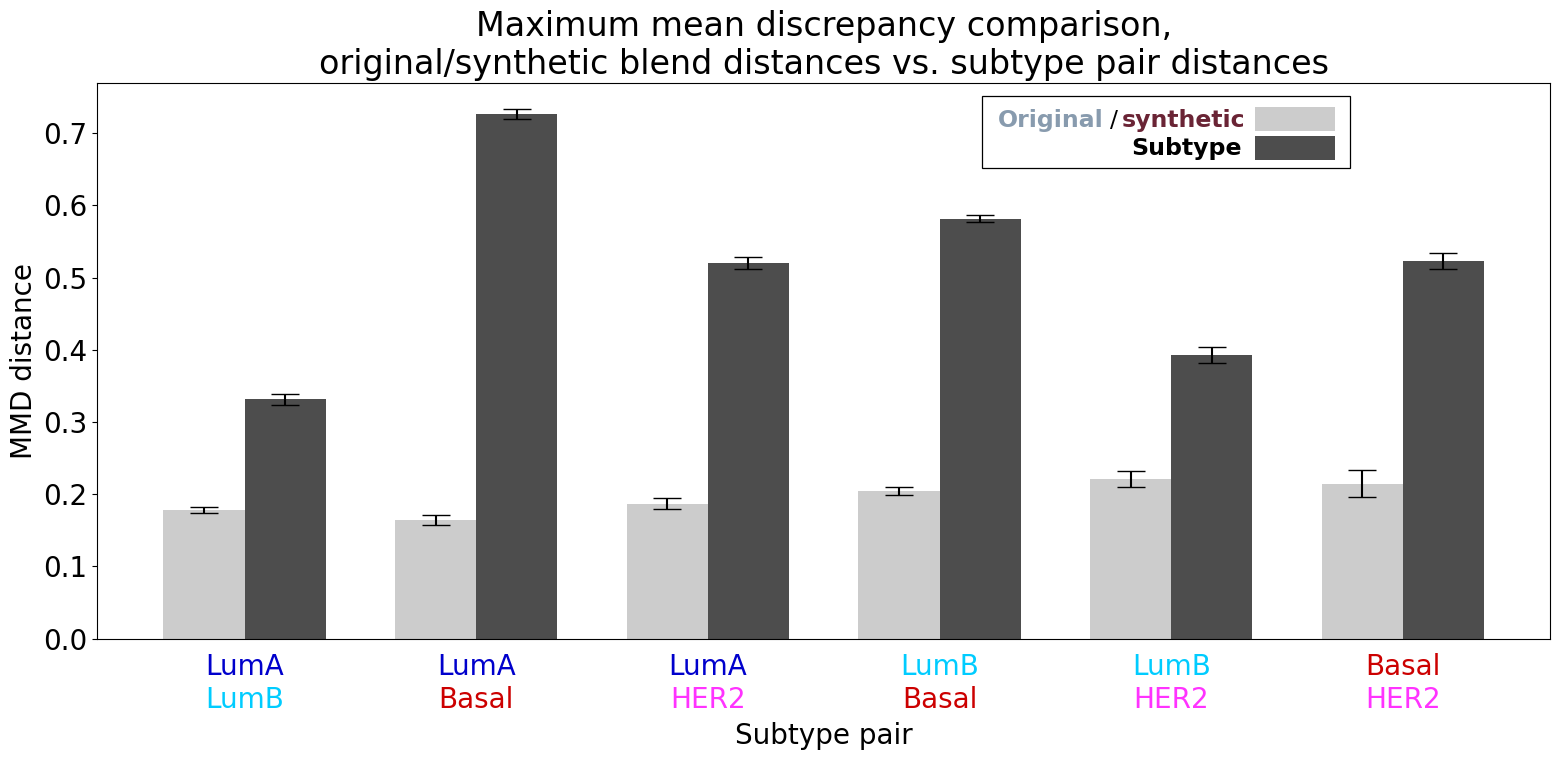

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Define color schemes
data_phase_rgbs = {'Original': (0.5333333333333333, 0.6078431372549019, 0.6823529411764706),
                   'Synthetic': (0.41568627450980394, 0.1411764705882353, 0.20784313725490197)}

subtype_rgbs = {'Basal': (0.8, 0.0, 0.0),
                'LumA': (0.0, 0.0, 0.8),
                'HER2': (1.0, 0.2, 1.0),
                'LumB': (0.0, 0.8, 1.0)}

# Calculate the mean and standard deviation for each 'Subtype_pair' and 'Comparison_type'
grouped_data = mmd_data.groupby(['Subtype_pair', 'Comparison_type'])['MMD_stat'].agg(['mean', 'std']).reset_index()
grouped_data['order'] = grouped_data['Subtype_pair'].apply(lambda x: pair_labels.index(eval(x)) if eval(x) in pair_labels else -1)
grouped_data_sorted = grouped_data.sort_values(by=['order', 'Comparison_type']).reset_index(drop=True)

# Initialize the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Set font sizes
plt.rcParams.update({'font.size': 20})
gray_shades = ['0.80', '0.3']

# Create bar plots
width = 0.35  # Width of the bars
ind = np.arange(len(grouped_data_sorted['Subtype_pair'].unique()))  # X locations for the groups

for i, comparison_type in enumerate(grouped_data_sorted['Comparison_type'].unique()):
    subset_data = grouped_data_sorted[grouped_data_sorted['Comparison_type'] == comparison_type]
    means = subset_data['mean']
    stds = subset_data['std']
    ax.bar(ind + i * width, means, width,
           label=comparison_type, yerr=stds, capsize=10,
           color=gray_shades[i])

# Add some text for labels, title, and axes ticks
ax.set_title(
    'Maximum mean discrepancy comparison,\noriginal/synthetic blend distances vs. subtype pair distances')
ax.set_ylabel('MMD distance')
ax.set_xlabel('Subtype pair', labelpad = 60)

# Remove default x-ticks
ax.set_xticks([])

# Add custom x-tick labels with dual colors
for i, pair in enumerate(grouped_data_sorted['Subtype_pair'].unique()):
    subtype1, subtype2 = eval(pair)  # Convert string to tuple
    ax.text(ind[i] + width/2, -0.02, subtype1, color=subtype_rgbs[subtype1],
            # rotation=55,
            ha='center', va='top', fontsize=20)
    ax.text(ind[i] + width/2, -0.065, subtype2, color=subtype_rgbs[subtype2],
            # rotation=55,
            ha='center', va='top', fontsize=20)

# Add full custom legend using axes coords
x_anchor1 = .62
y_1 = .92
y_offset = .05
ax.text(x_anchor1, y_1, 'Original', transform=ax.transAxes, fontsize=17, color=data_phase_rgbs['Original'], fontweight='bold')
ax.text(x_anchor1+.077, y_1, '/', transform=ax.transAxes, fontsize=17)
ax.text(x_anchor1+.085, y_1, 'synthetic', transform=ax.transAxes, fontsize=17, color=data_phase_rgbs['Synthetic'], fontweight='bold')
ax.text(x_anchor1+.092, y_1-y_offset, 'Subtype', transform=ax.transAxes, fontsize=17, color='black', fontweight='bold')

xy = (0.797, .811)
width = .05
height = .03

rectangle_light = mpatches.Rectangle(xy, width, height, facecolor = gray_shades[0])
rectangle_light.set_transform(fig.transFigure)
ax.add_patch(rectangle_light)

rectangle_dark = mpatches.Rectangle((xy[0], 0.775), width, height, facecolor = gray_shades[1])
rectangle_dark.set_transform(fig.transFigure)
ax.add_patch(rectangle_dark)

rectangle_border = mpatches.Rectangle((.626, 0.765), .23, .09, fill=False, edgecolor = 'black',
                                     lw=.9)
rectangle_border.set_transform(fig.transFigure)
ax.add_patch(rectangle_border)

plt.tight_layout()
plt.savefig('mnt/data/MMD_mpatch_v0.png', dpi=300)
plt.show()